In [2]:
import tensorflow as tf
import os
from datetime import datetime
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Lambda, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import numpy as np


In [9]:
def preprocess_image(image, label):
    angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
    mirrored_angles = tf.constant([80.0, 75.0, 70.0, 65.0, 60.0, 55.0, 50.0, 130.0, 125.0, 120.0, 115.0, 110.0, 105.0, 100.0, 95.0, 90.0, 85.0], dtype=tf.float32)
    image = tf.image.resize(image, [192, 192]) 
    image = tf.image.random_flip_left_right(image, seed=123)

    def adjust_label(label):
        # Assuming label is a batch of one-hot encoded labels with shape [batch_size, num_classes]
        # Find the indices of the max value in each row (highest probability class)
        label_indices = tf.argmax(label, axis=-1)
        
        # For each label index, find the corresponding angle and then find the mirrored angle's index
        angles_batch = tf.gather(angles, label_indices)
        
        # This operation needs to be adapted to handle a batch of angles
        # Use tf.map_fn to apply the finding operation across the batch
        def find_mirrored_index(angle):
            # Find the index of this angle in the mirrored_angles list
            mirrored_index = tf.where(tf.equal(mirrored_angles, angle))
            return tf.reshape(mirrored_index, [-1])[0]

        mirrored_indices = tf.map_fn(find_mirrored_index, angles_batch, dtype=tf.int64)
        
        # Create new one-hot encoded labels based on the mirrored indices
        new_labels = tf.one_hot(mirrored_indices, depth=tf.size(angles), dtype=label.dtype)
        
        return new_labels

    flipped_image = tf.image.flip_left_right(image)
    is_flipped = tf.reduce_any(flipped_image != image)
    
    # Use tf.cond to conditionally adjust the label, ensuring the output matches the input type
    label = tf.cond(is_flipped, lambda: adjust_label(label), lambda: tf.identity(label))
    
    return tf.cast(image, tf.float32), label

In [ ]:
directory = '../../data/angle_class_data'
finetuning = False

train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names = ['65.0','50.0','75.0','115.0','130.0','85.0','105.0','120.0','95.0','80.0','110.0','125.0','90.0','100.0','60.0','70.0','55.0'],
            color_mode='rgb',
            batch_size=128,
            image_size = (192,256),
            shuffle=True,
            seed=123,
            validation_split=0.15,
            subset="training").map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names = ['65.0','50.0','75.0','115.0','130.0','85.0','105.0','120.0','95.0','80.0','110.0','125.0','90.0','100.0','60.0','70.0','55.0'],
            color_mode='rgb',
            batch_size=128,
            image_size = (192,256),
            shuffle=True,
            seed=123,
            validation_split=0.15,
            subset="validation").map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

2024-04-12 14:19:02.845070: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)
(240, 320, 3)


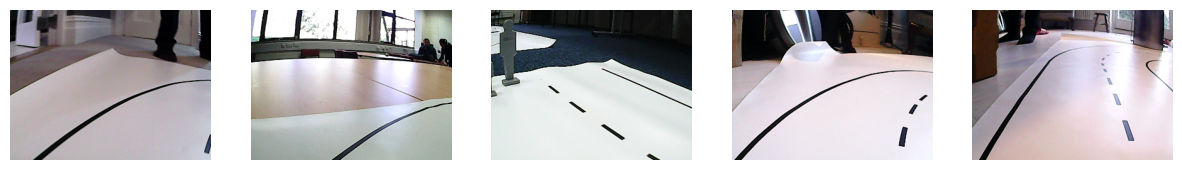

In [10]:
# Take one batch from the dataset and cache it for comparison
cached_batch = None
for images, labels in train_ds.take(1):
    cached_batch = (images, labels)

# Display the first 5 images from the cached batch before preprocessing
plt.figure(figsize=(15, 15))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(cached_batch[0][i].numpy().astype("uint8"))
    print(cached_batch[0][i].shape)
    plt.axis("off")
plt.show()

# # Apply preprocessing to the cached batch
# preprocessed_images = tf.map_fn(lambda x: preprocess_image(x, None)[0], cached_batch[0], fn_output_signature=tf.float32)

# # Display the first 5 images from the preprocessed batch
# plt.figure(figsize=(15, 15))
# for i in range(5):
#     ax = plt.subplot(1, 5, i + 1)
#     plt.imshow(preprocessed_images[i].numpy().astype("uint8"))
#     print(preprocessed_images[i].shape)
#     plt.axis("off")
# plt.show()

In [1]:
import tensorflow_addons as tfa


/Users/shayan/anaconda3/envs/my_adc/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
!pip install --quiet vit-keras

from vit_keras import vit

## Utils
### 1. Gaussian Blur
### 2. SpatialPyramidPooling
### Improvements: Restructing, ...

In [3]:
class GaussianBlurLayer(Layer):
    def __init__(self, kernel_size=(5, 5), sigma=0, **kwargs):
        super(GaussianBlurLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma = sigma

    def call(self, inputs):
        # Wrap the cv2 GaussianBlur operation in tf.py_function to ensure compatibility with TensorFlow tensors
        def blur_function(image):
            if not isinstance(image, np.ndarray):
                print("Image is not a numpy array. Attempting conversion.")
            # image is a numpy array here
            blurred_image = cv2.GaussianBlur(image, self.kernel_size, self.sigma)
            return blurred_image

        # Apply the blur function on each input
        blurred_inputs = tf.map_fn(lambda img: tf.numpy_function(blur_function, [img], tf.float32), inputs, fn_output_signature=tf.float32)
        blurred_inputs.set_shape(inputs.shape)  # Ensure output shape is set correctly
        return blurred_inputs

    def get_config(self):
        config = super(GaussianBlurLayer, self).get_config()
        config.update({
            'kernel_size': self.kernel_size,
            'sigma': self.sigma,
        })
        return config

## Pipeline
### 1. Loading
### 2. Preprocessing (Submission files)
### 3. Augmentation
### 4. Results + Confusion Matrix

##